# PA005: High Value Customer Indentification ( Insiders )

## Planejamento da Solução ( IOT )

### Input - Entrada

1. ***Problema de Negócio***
  - Selecionar os clientes mais valiosos para integrar um programa de Fidelização
   
2. ***Conjunto de Dados***
  - Vendas de um e-commerce online, durane o período de um ano.


### Output - Saída

1. A indicação das pessoas que farão parte do programa de Insiders


  - Lista: 
  
              client_id | is_insider  |
                104224  |   yes/1   
                332131  |   no/0


2. Relatório com as respostas das perguntas de negócio

- Quem são as pessoas elegíveis para participar do programa de Insiders ?
- Quantos clientes farão parte do grupo?
- Quais as principais características desses clientes ?
- Qual a porcentagem de contribuição do faturamento, vinda do Insiders ?
- Qual a expectativa de faturamento desse grupo para os próximos meses ?
- Quais as condições para uma pessoa ser elegível ao Insiders ?
- Quais as condições para uma pessoa ser removida do Insiders ?
- Qual a garantia que o programa Insiders é melhor que o restante da base ?
- Quais ações o time de marketing pode realizar para aumentar o faturamento?


### Tasks - Tarefas

##### ***1. Quem são as pessoas elegíveis para participar do programa de Insiders ?***
- ***O que é ser elegível? O que são clientes de maior "valor"?***

- ***Faturamento:***

        - Alto Ticket Médio.
        - Alto LTV (Live Time Value).
        - Baixa Recência.
        - Alto Basket Size.
        - Baixa Probabilidade de Churn.
        - Previsão de LTV.
        - Alta propensão de compra.
- ***Custo:***

        - Baixo custo de devolução

- ***Experiência de compra:***

        - Média alta das avaliações
        

    
##### ***2. Quantos clientes farão parte do grupo?***


        - Número total de clientes
        - % do grupo de Insiders

##### ***3. Quais as principais características desses clientes ?***
- ***Escrever características do cliente:***

        - Idade
        - Localização
- ***Escrever características do consumo:***

        - Atributos de clusterização
        

##### ***4. Qual a porcentagem de contribuição do faturamento, vinda do Insiders ?***

- ***Faturamento total do ano***

- ***Faturamento do grupo Insiders***


##### 5. ***Qual a expectativa de faturamento desse grupo para os próximos meses ?***

- ***LTV do grupo Insiders***

- ***Análise de Cohort*** 

##### 6. ***Quais as condições para uma pessoa ser elegível ao Insiders ?***

- ***Definir periodicidade ( 1 mês, 3 meses )***

- ***A pessoa precisa ser similar ou parecido com uma pessoa do grupo***

##### 7. ***Quais as condições para uma pessoa ser removida do Insiders ?***

- ***Definir periodicidade ( 1 mês, 3 meses )***

- ***A pessoa precisa ser dissimilar ou não parecida com uma pessoa do grupo***

##### 8. ***Qual a garantia que o programa Insiders é melhor que o restante da base ?***

- ***Teste A/B***

- ***Teste de Hipóteses***

##### 9. ***Quais ações o time de marketing pode realizar para aumentar o faturamento?***

- ***Desconto***
- ***Preferência de Compra***
- ***Frente***
- ***Visita***


## 0.0. Imports

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns

from matplotlib import pyplot as plt
from IPython.display import HTML
from sklearn import cluster as c
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer
from sklearn import metrics as m
from sklearn import preprocessing as pp
from plotly import express as px
import umap.umap_ as umap

### 0.1. Helper Functions

In [3]:
def jupyter_settings():
    %matplotlib inline
    %pylab inline

    plt.style.use( 'ggplot' )
    plt.rcParams[ 'figure.figsize' ] = [24, 9]
    plt.rcParams[ 'font.size' ] = 24

    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )

    sns.set()

jupyter_settings() 

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


### 0.2. Load Dataset

In [4]:
# load data
df_raw = pd.read_csv('/Users/thiago/Thiago/Data_Science/comunidade_ds/insiders_clustering/data/raw/ecommerce.csv', encoding='unicode_escape' )

# drop extra column
df_raw = df_raw.drop( columns=['Unnamed: 8'], axis=1 )

In [5]:
df_raw.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,29-Nov-16,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,29-Nov-16,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,29-Nov-16,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,29-Nov-16,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,29-Nov-16,3.39,17850.0,United Kingdom


## <font color='red'> 1.0. Descrição dos Dados </font>

In [19]:
df1 = df_raw.copy()

### 1.1. Rename Columns

In [20]:
cols_new = [ 'invoice_no', 'stock_code', 'description', 'quantity', 'invoice_date',
       'unit_price', 'customer_id', 'country' ]
df1.columns = cols_new

### 1.2. Data Dimensions

In [21]:
print( 'Number of rows: {}'.format( df1.shape[0] ) )
print( 'Number of cols: {}'.format( df1.shape[1] ) )

Number of rows: 541909
Number of cols: 8


### 1.3. Data Types

In [22]:
df1.dtypes

invoice_no       object
stock_code       object
description      object
quantity          int64
invoice_date     object
unit_price      float64
customer_id     float64
country          object
dtype: object

### 1.4. Check NA

In [23]:
df1.isna().sum()

invoice_no           0
stock_code           0
description       1454
quantity             0
invoice_date         0
unit_price           0
customer_id     135080
country              0
dtype: int64

### 1.5. Replace NA

In [24]:
df_missing = df1.loc[df1['customer_id'].isna(), :]
df_not_missing = df1.loc[~df1['customer_id'].isna(), :]

In [50]:
# create reference
df_backup = pd.DataFrame( df_missing['invoice_no'].drop_duplicates() )
df_backup['customer_id'] = np.arange( 19000, 19000+len( df_backup ), 1)

# merge original with reference dataframe
df1 = pd.merge( df1, df_backup, on='invoice_no', how='left' )

# coalesce
df1['customer_id'] = df1['customer_id_x'].combine_first( df1['customer_id_y'] )

# drop extra columns
df1 = df1.drop( columns=['customer_id_x', 'customer_id_y'], axis=1 )

df1.head()


,invoice_no,stock_code,description,quantity,invoice_date,unit_price,country,customer_id
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,29-Nov-16,2.55,United Kingdom,17850.0
1,536365,71053,WHITE METAL LANTERN,6,29-Nov-16,3.39,United Kingdom,17850.0
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,29-Nov-16,2.75,United Kingdom,17850.0
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,29-Nov-16,3.39,United Kingdom,17850.0
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,29-Nov-16,3.39,United Kingdom,17850.0


In [52]:
df1.isna().sum()

invoice_no         0
stock_code         0
description     1454
quantity           0
invoice_date       0
unit_price         0
country            0
customer_id        0
dtype: int64

### 1.6. Change Types

In [53]:
# invoice_date
df1['invoice_date'] = pd.to_datetime( df1['invoice_date'], format='%d-%b-%y' )

# customer_id
df1['customer_id'] = df1['customer_id'].astype(int)

In [55]:
df1.dtypes

invoice_no              object
stock_code              object
description             object
quantity                 int64
invoice_date    datetime64[ns]
unit_price             float64
country                 object
customer_id              int64
dtype: object

### 1.7. Descriptive Statistics

In [56]:
num_attributes = df1.select_dtypes( include=['int64', 'float64'] )
cat_attributes = df1.select_dtypes( exclude=['int64', 'float64', 'datetime64[ns]'] )

#### 1.7.1. Numerical Attributes

In [57]:
# central tendency - mean, median
ct1 = pd.DataFrame( num_attributes.apply( np.mean ) ).T
ct2 = pd.DataFrame( num_attributes.apply( np.median ) ).T

# dispersion - desvio padrão, mínimo, máximo, range, skew, kurtosis
d1 = pd.DataFrame( num_attributes.apply( np.std ) ).T
d2 = pd.DataFrame( num_attributes.apply( np.min ) ).T
d3 = pd.DataFrame( num_attributes.apply( np.max ) ).T
d4 = pd.DataFrame( num_attributes.apply( lambda x: x.max() - x.min() ) ).T
d5 = pd.DataFrame( num_attributes.apply( lambda x: x.skew() ) ).T
d6 = pd.DataFrame( num_attributes.apply( lambda x: x.kurtosis() ) ).T

# concatenate
m = pd.concat( [d2, d3, d4, ct1, ct2, d1, d5, d6] ).T.reset_index()
m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'mediana', 'std', 'skew', 'kurtosis']
m


,attributes,min,max,range,mean,mediana,std,skew,kurtosis
0,quantity,-80995.00,80995.0,161990.00,9.552250,3.00,218.080957,-0.264076,119769.160031
1,unit_price,-11062.06,38970.0,50032.06,4.611114,2.08,96.759764,186.506972,59005.719097
2,customer_id,12346.00,22709.0,10363.00,16688.840453,16249.00,2911.408666,0.487449,-0.804287


#### <font color='red'> 1.7.1.1. Numerical Attributes - Investigating </font>

1. Quantidade negativa ( pode ser devolução?? )
2. Preço unitário igual a zero ( pode ser promoção?? )

#### 1.7.2. Categorical Attributes

In [58]:
cat_attributes.head()

,invoice_no,stock_code,description,country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,United Kingdom
1,536365,71053,WHITE METAL LANTERN,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,United Kingdom


<b>Invoice No</b>

In [59]:
# problema: Temos o invoice com letras e numeros
#df1['invoice_no'].astype( int )

# Identificação
df_letter_invoices = df1.loc[df1['invoice_no'].apply( lambda x: bool ( re.search( '[^0-9]+', x ) ) ), :]
df_letter_invoices.head()

print( 'Total number os invoices: {}'.format( len ( df_letter_invoices ) ) ) 
print( 'Total number os negative quantity: {}'.format( len( df_letter_invoices[df_letter_invoices['quantity'] < 0 ] ) ) )

Total number os invoices: 9291
Total number os negative quantity: 9288


In [60]:
#cat_attributes['invoice_no'].astype( int )
len( cat_attributes.loc[ cat_attributes['invoice_no'].apply( lambda x: bool( re.search( '[^0-9]+', x ) ) ), 'invoice_no'].drop_duplicates() )
#cat_attributes.loc[173995, : ]

3839

<b>Stock Code</b>

In [61]:
# stock code
#at_least_one_string = cat_attributes.loc[ cat_attributes['stock_code'].apply( lambda x: bool ( re.search( '[^0-9+]', x ) ) ), 'stock_code'].head()

#print( at_least_one_string )

#
#cat_attributes.loc[cat_attributes['stock_code'].apply( lambda x: bool( re.search( '^[a-zA-Z]+$', x ) ) ), 'stock_code'].unique() 
df1.loc[cat_attributes['stock_code'].apply( lambda x: bool( re.search( '^[a-zA-Z]+$', x ) ) ), :].head()

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,country,customer_id
45,536370,POST,POSTAGE,3,2016-11-29,18.00,France,12583
141,C536379,D,Discount,-1,2016-11-29,27.50,United Kingdom,14527
386,536403,POST,POSTAGE,1,2016-11-29,15.00,Netherlands,12791
1123,536527,POST,POSTAGE,1,2016-11-29,18.00,Germany,12662
1814,536544,DOT,DOTCOM POSTAGE,1,2016-11-29,569.77,United Kingdom,19001


In [62]:
# check stock codes only characters
df1.loc[df1['stock_code'].apply( lambda x: bool ( re.search( '^[a-zA-Z]+$', x ) ) ), 'stock_code'].unique()

# Ação:
## 1. Remove stock_code in ['POST', 'D', 'M', 'PADS', 'DOT', 'CRUK']

array(['POST', 'D', 'DOT', 'M', 'S', 'AMAZONFEE', 'm', 'DCGSSBOY',
       'DCGSSGIRL', 'PADS', 'B', 'CRUK'], dtype=object)

<b>Description</b>

In [63]:
df1.head()

# Ação: deletar description

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,country,customer_id
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2016-11-29,2.55,United Kingdom,17850
1,536365,71053,WHITE METAL LANTERN,6,2016-11-29,3.39,United Kingdom,17850
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2016-11-29,2.75,United Kingdom,17850
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2016-11-29,3.39,United Kingdom,17850
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2016-11-29,3.39,United Kingdom,17850


<b>Country</b>

In [64]:
len( df1['country'].unique() )

38

In [65]:
df1['country'].value_counts( normalize=True)

United Kingdom          0.914320
Germany                 0.017521
France                  0.015790
EIRE                    0.015124
Spain                   0.004674
Netherlands             0.004375
Belgium                 0.003818
Switzerland             0.003694
Portugal                0.002803
Australia               0.002323
Norway                  0.002004
Italy                   0.001482
Channel Islands         0.001399
Finland                 0.001283
Cyprus                  0.001148
Sweden                  0.000853
Unspecified             0.000823
Austria                 0.000740
Denmark                 0.000718
Japan                   0.000661
Poland                  0.000629
Israel                  0.000548
USA                     0.000537
Hong Kong               0.000531
Singapore               0.000423
Iceland                 0.000336
Canada                  0.000279
Greece                  0.000269
Malta                   0.000234
United Arab Emirates    0.000125
European C

In [66]:
df1[['customer_id', 'country']].drop_duplicates().groupby( 'country' ).count().reset_index().sort_values( 'customer_id', ascending=False )

,country,customer_id
36,United Kingdom,7587
14,Germany,95
13,France,90
10,EIRE,44
31,Spain,31
3,Belgium,25
33,Switzerland,24
27,Portugal,20
19,Italy,15
16,Hong Kong,15


## <font color='red'> 2.0. Filtragem das Variáveis </font>

In [67]:
df2 = df1.copy()

In [68]:
# ===== Numerical Attributes ======
# unit price > 0.04
df2 = df2.loc[df2['unit_price'] > 0.04, :]

# ===== Categorical Attributes ======
# stock code != [ POST, D, M, DOT, CRUK ]
df2 = df2[~df2['stock_code'].isin( ['POST', 'D', 'DOT', 'M', 'S', 'AMAZONFEE', 'm', 'DCGSSBOY',
       'DCGSSGIRL', 'PADS', 'B', 'CRUK']) ] 

# description
df2 = df2.drop( columns='description', axis=1 )

# map
df2 = df2[~df2['country'].isin( ['European Community', 'Unspecified'] ) ]

## quantity - Negative numbers means product returns
df2_returns = df2.loc[df2['quantity'] < 0, :]
df2_purchase = df2.loc[df2['quantity'] >= 0, :]

## <font color='red'> 3.0. Feature Engineering </font>

In [69]:
df3 = df2.copy()

### 3.1. Feature Creation

In [64]:
# data reference
df_ref = df3.drop( ['invoice_no', 'stock_code','quantity', 'invoice_date', 'unit_price', 'country' ], axis=1 ).drop_duplicates( ignore_index=True)

#### 3.1.1. Gross Revenue

In [ ]:
# Gross Revenue ( Faturamento ) quantity * price
df2_purchase.loc[:, 'gross_revenue'] = df2_purchase.loc[:, 'quantity'] * df2_purchase.loc[:, 'unit_price']

# Monetary
df_monetary = df2_purchase.loc[:, ['customer_id', 'gross_revenue']].groupby( 'customer_id').sum().reset_index()
df_ref = pd.merge( df_ref, df_monetary, how='left', on='customer_id' )

#### 3.1.2. Recency - Day from last Purchase

In [ ]:
# Recency - It depends on product returns
df_recency = df2_purchase.loc[:, ['customer_id', 'invoice_date']].groupby( 'customer_id' ).max().reset_index()
df_recency['recency_days'] = ( df2_purchase['invoice_date'].max() - df_recency['invoice_date'] ).dt.days
df_recency = df_recency[['customer_id', 'recency_days']].copy()
df_ref = pd.merge( df_ref, df_recency, how='left', on='customer_id' )

#### 3.1.3. Quantity of Products Purchased

In [ ]:
# Número de Produtos - It depends os product returns
df_frequency = df2_purchase.loc[:, ['customer_id', 'invoice_no']].drop_duplicates().groupby( 'customer_id' ).count().reset_index()
df_ref = pd.merge( df_ref, df_frequency, how='left', on='customer_id' )

#### 3.1.4. Average Ticket Value

In [ ]:
# Average Ticket
df_avg_ticket = df2_purchase.loc[:, ['customer_id', 'gross_revenue']].groupby( 'customer_id' ).mean().reset_index().rename( columns={'gross_revenue' : 'avg_ticket' } ) 
#df_avg_ticket['avg_ticket'] = np.round( df_avg_ticket['avg_ticket'], 2 )
df_ref = pd.merge( df_ref, df_avg_ticket, how='left', on='customer_id' )

#### 3.1.5. Average Recency Days

#### 3.1.6. Devoluções


#### 3.1.7. Basket Size

In [66]:
df_ref.isna().sum()

customer_id       0
gross_revenue    27
recency_days     27
invoice_no       27
avg_ticket       27
dtype: int64

In [67]:
df_ref.head()

,customer_id,gross_revenue,recency_days,invoice_no,avg_ticket
0,17850,5391.21,372.0,34.0,18.152222
1,13047,3232.59,56.0,9.0,18.904035
2,12583,6705.38,2.0,15.0,28.902500
3,13748,948.25,95.0,5.0,33.866071
4,15100,876.00,333.0,3.0,292.000000


In [65]:
# # data reference

# df_ref = df3.drop( ['invoice_no', 'stock_code', 'description', 'quantity',
#                     'invoice_date', 'unit_price', 'country'],
#                      axis=1 ).drop_duplicates( ignore_index=True)

# df_ref.head()
# # Gross Renevue ( Faturamento - quantity * price)
# df3['gross_revenue'] = df3['quantity'] * df3['unit_price']

# # Monetary
# df_monetary = df3[['customer_id', 'gross_revenue']].groupby( 'customer_id' ).sum().reset_index()
# df_ref = pd.merge( df_ref, df_monetary, on='customer_id', how='left' )

# # Recency - Last Day Purchase
# df_recency = df3[['customer_id', 'invoice_date']].groupby( 'customer_id' ).max().reset_index()
# df_recency['recency_days'] = ( df3['invoice_date'].max() - df_recency['invoice_date'] ).dt.days
# df_recency = df_recency[['customer_id', 'recency_days']].copy()
# df_ref = pd.merge( df_ref, df_recency, on='customer_id', how='left' )

# # Frequency
# df_freq = df3[['customer_id', 'invoice_no']].drop_duplicates().groupby( 'customer_id' ).count().reset_index()
# df_ref = pd.merge( df_ref, df_freq, on='customer_id', how='left' )

# # Avg Ticket
# df_avg_ticket = df3[['customer_id', 'gross_revenue']].groupby('customer_id').mean().reset_index().rename( columns={'gross_revenue':'avg_ticket'} )
# df_ref = pd.merge( df_ref, df_avg_ticket, on='customer_id', how='left' )

,customer_id
0,17850
1,13047
2,12583
3,13748
4,15100


## <font color='red'> 4.0. EDA ( Exploratory Data Analysis )</font>

In [68]:
df4 = df_ref.dropna().copy()

In [69]:
df4.isna().sum()

customer_id      0
gross_revenue    0
recency_days     0
invoice_no       0
avg_ticket       0
dtype: int64

## <font color='red'> 5.0. Data Preparation</font>

In [84]:
df5 = df4.copy()

/Users/thiago/Thiago/Data_Science/comunidade_ds/insiders_clustering/ins_clustenv/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/thiago/Thiago/Data_Science/comunidade_ds/insiders_clustering/ins_clustenv/lib/python3.10/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='gross_revenue'>

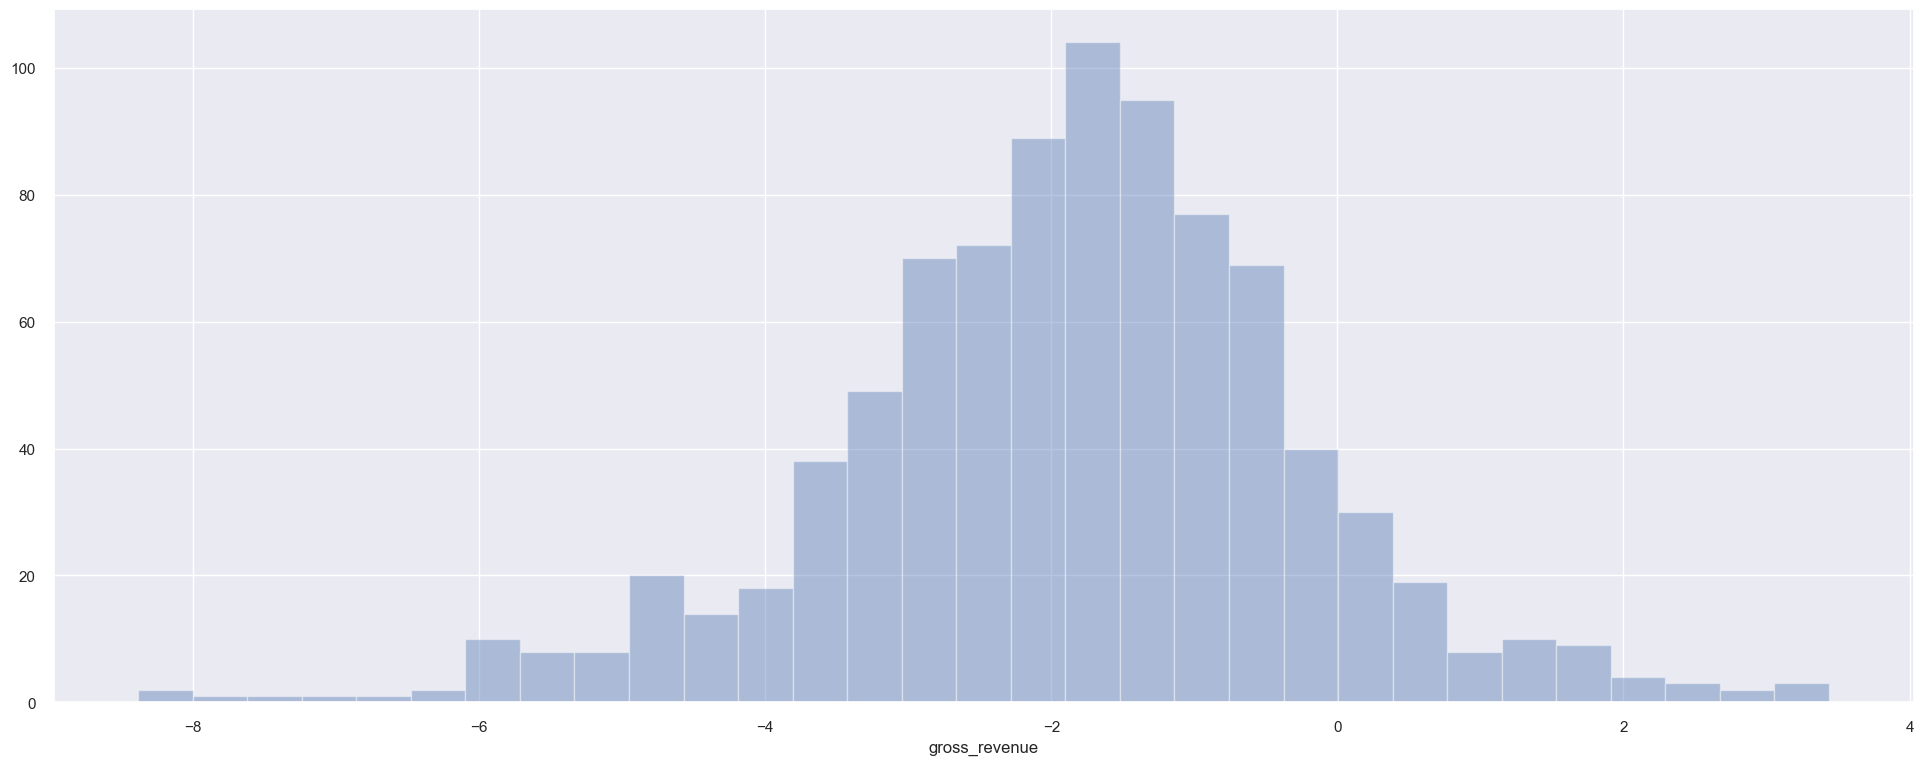

In [129]:
sns.distplot( np.log( df5['gross_revenue'] ), kde=False)

In [85]:
df5.head()

,customer_id,gross_revenue,recency_days,invoice_no,avg_ticket
0,17850,5391.21,372.0,34.0,18.152222
1,13047,3232.59,56.0,9.0,18.904035
2,12583,6705.38,2.0,15.0,28.902500
3,13748,948.25,95.0,5.0,33.866071
4,15100,876.00,333.0,3.0,292.000000


In [134]:
ss = pp.StandardScaler()

df5['gross_revenue'] = ss.fit_transform( df5[['gross_revenue']])
df5['recency_days'] = ss.fit_transform( df5[['recency_days']])
df5['invoice_no'] = ss.fit_transform( df5[['invoice_no']])
df5['avg_ticket'] = ss.fit_transform( df5[['avg_ticket']])
#df5['returns'] = ss.fit_transform( df5[['returns']])

In [136]:
df5.head()

,customer_id,gross_revenue,recency_days,invoice_no,avg_ticket
0,17850,0.378073,2.791512,3.893141,-0.033934
1,13047,0.135815,-0.361004,0.621632,-0.033422
2,12583,0.525560,-0.899726,1.406794,-0.026617
3,13748,-0.120552,0.028072,0.098191,-0.023239
4,15100,-0.128660,2.402435,-0.163530,0.152448


/Users/thiago/Thiago/Data_Science/comunidade_ds/insiders_clustering/ins_clustenv/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/thiago/Thiago/Data_Science/comunidade_ds/insiders_clustering/ins_clustenv/lib/python3.10/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='gross_revenue', ylabel='Density'>

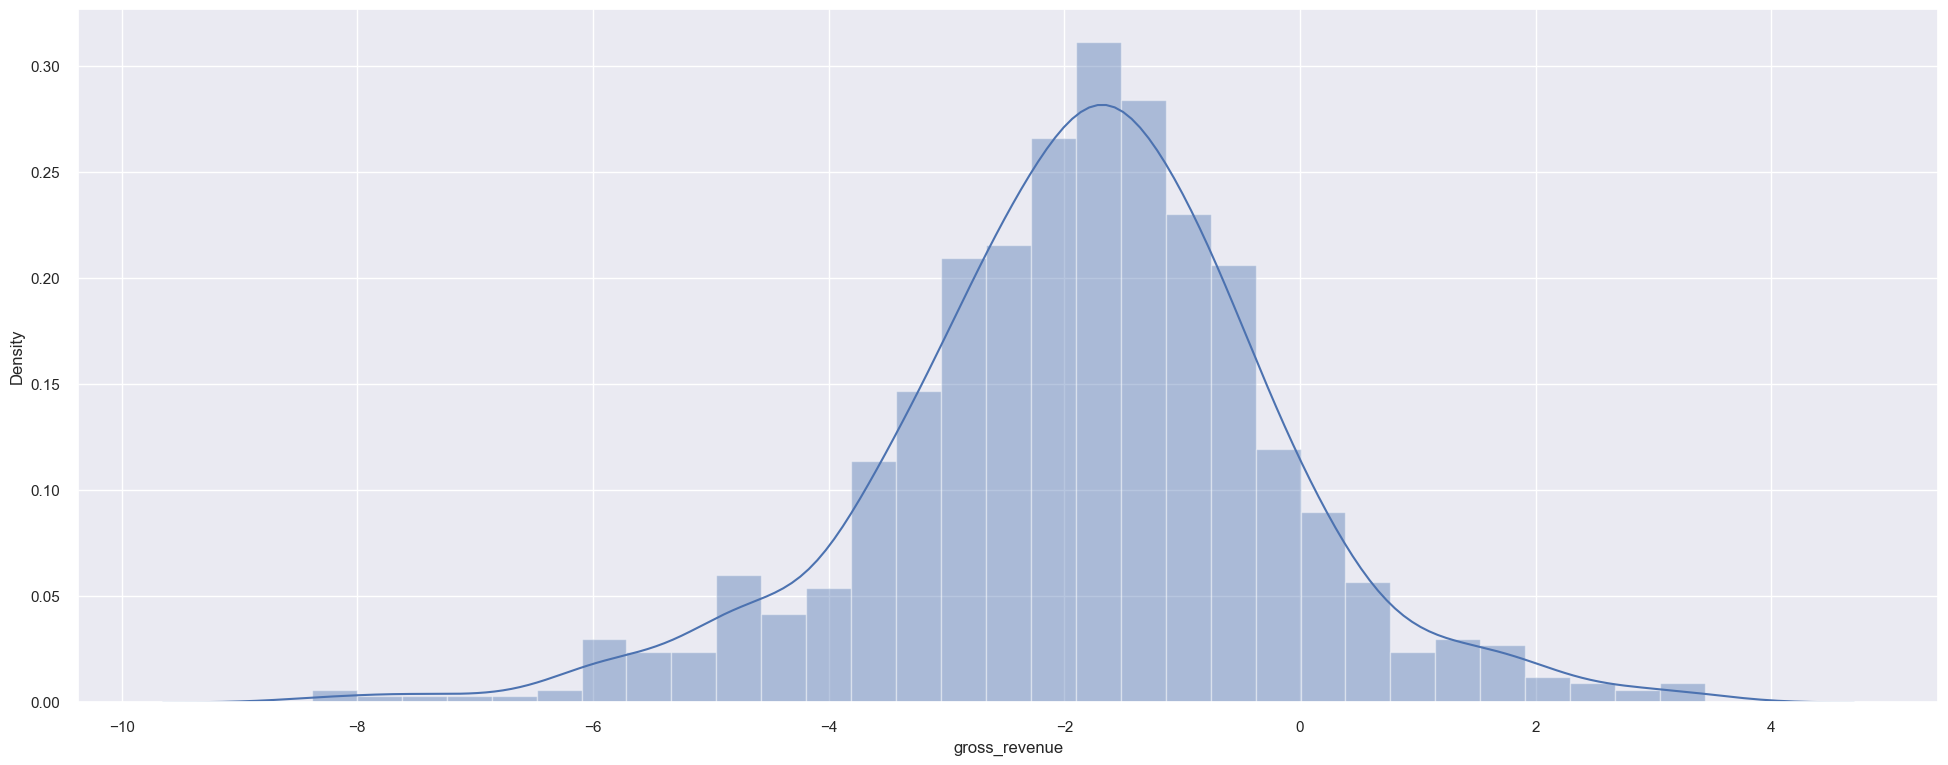

In [144]:
sns.distplot( np.log( df5['gross_revenue'] ))

## <font color='red'> 6.0. Feature Selection</font>

In [145]:
df6 = df5.copy()

## <font color='red'> 7.0. Hyperparameter Fine-Tunning </font>

In [146]:
X = df6.drop( columns=['customer_id'] )

In [147]:
clusters = [2, 3, 4, 5, 6, 7]

### 7.1. Within-Cluster Sum of Square ( WSS )

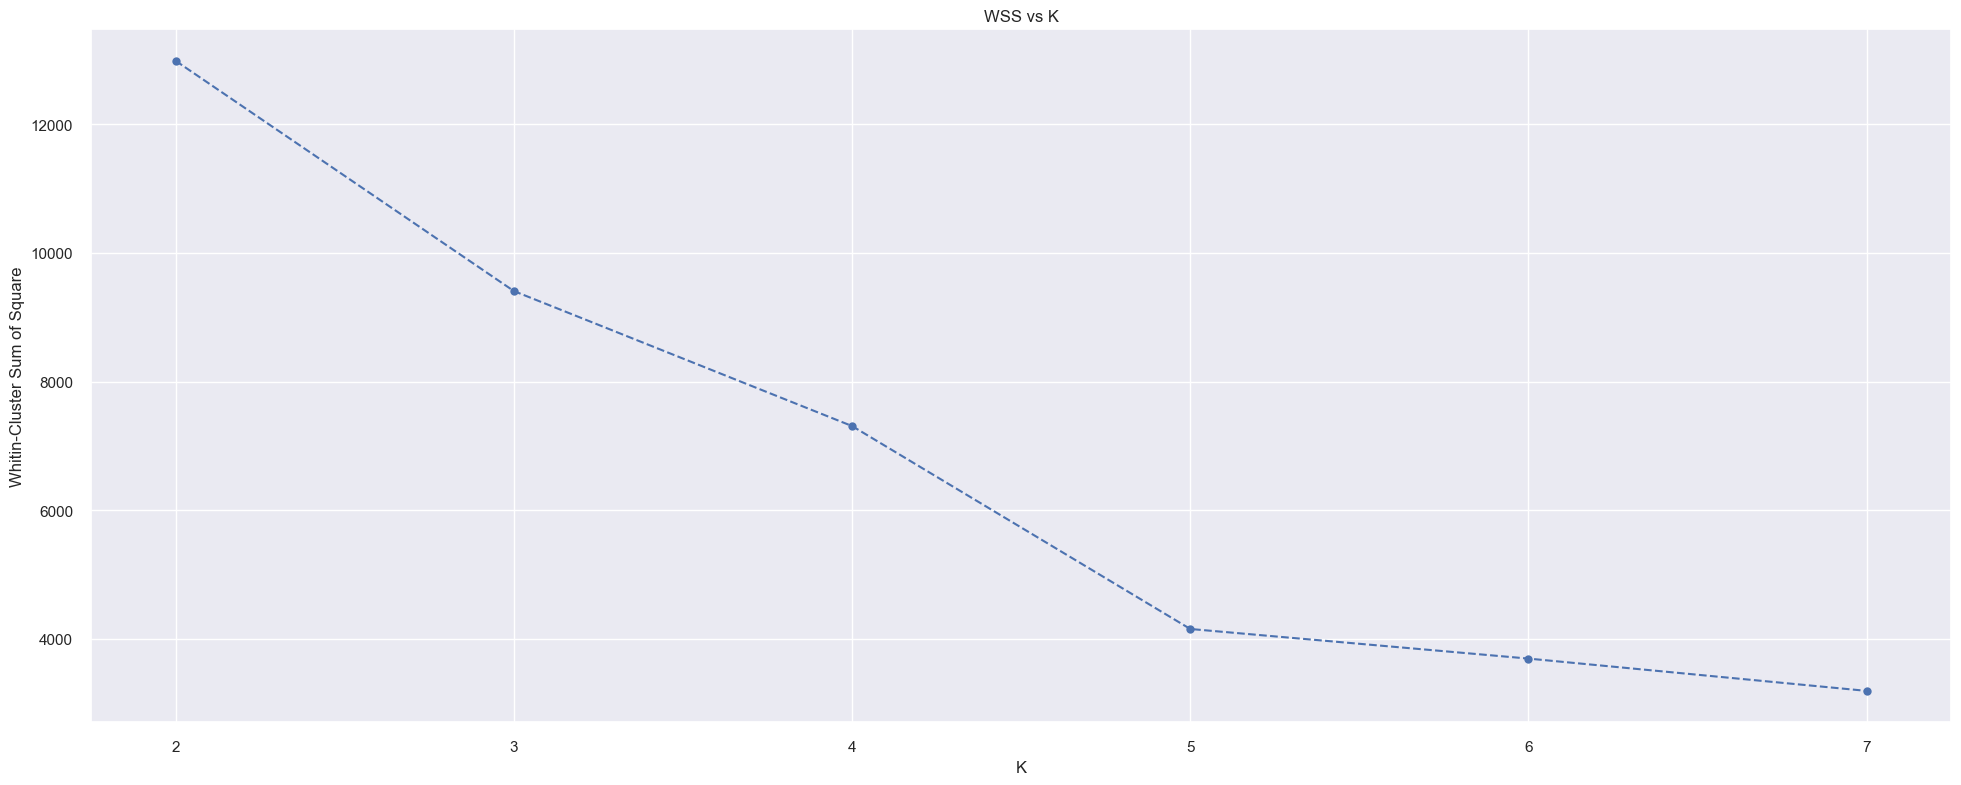

In [148]:
wss = []
for k in clusters:
    # model definition
    kmeans = c.KMeans( init='random', n_clusters=k, n_init=10, max_iter=300, random_state=42 )

    # model training
    kmeans.fit( X )

    # validation
    wss.append( kmeans.inertia_ )

# plot wss - Elbow Method
plt.plot( clusters, wss, linestyle='--', marker='o', color='b' );
plt.xlabel( 'K' );
plt.ylabel( 'Whitin-Cluster Sum of Square' );
plt.title( 'WSS vs K');

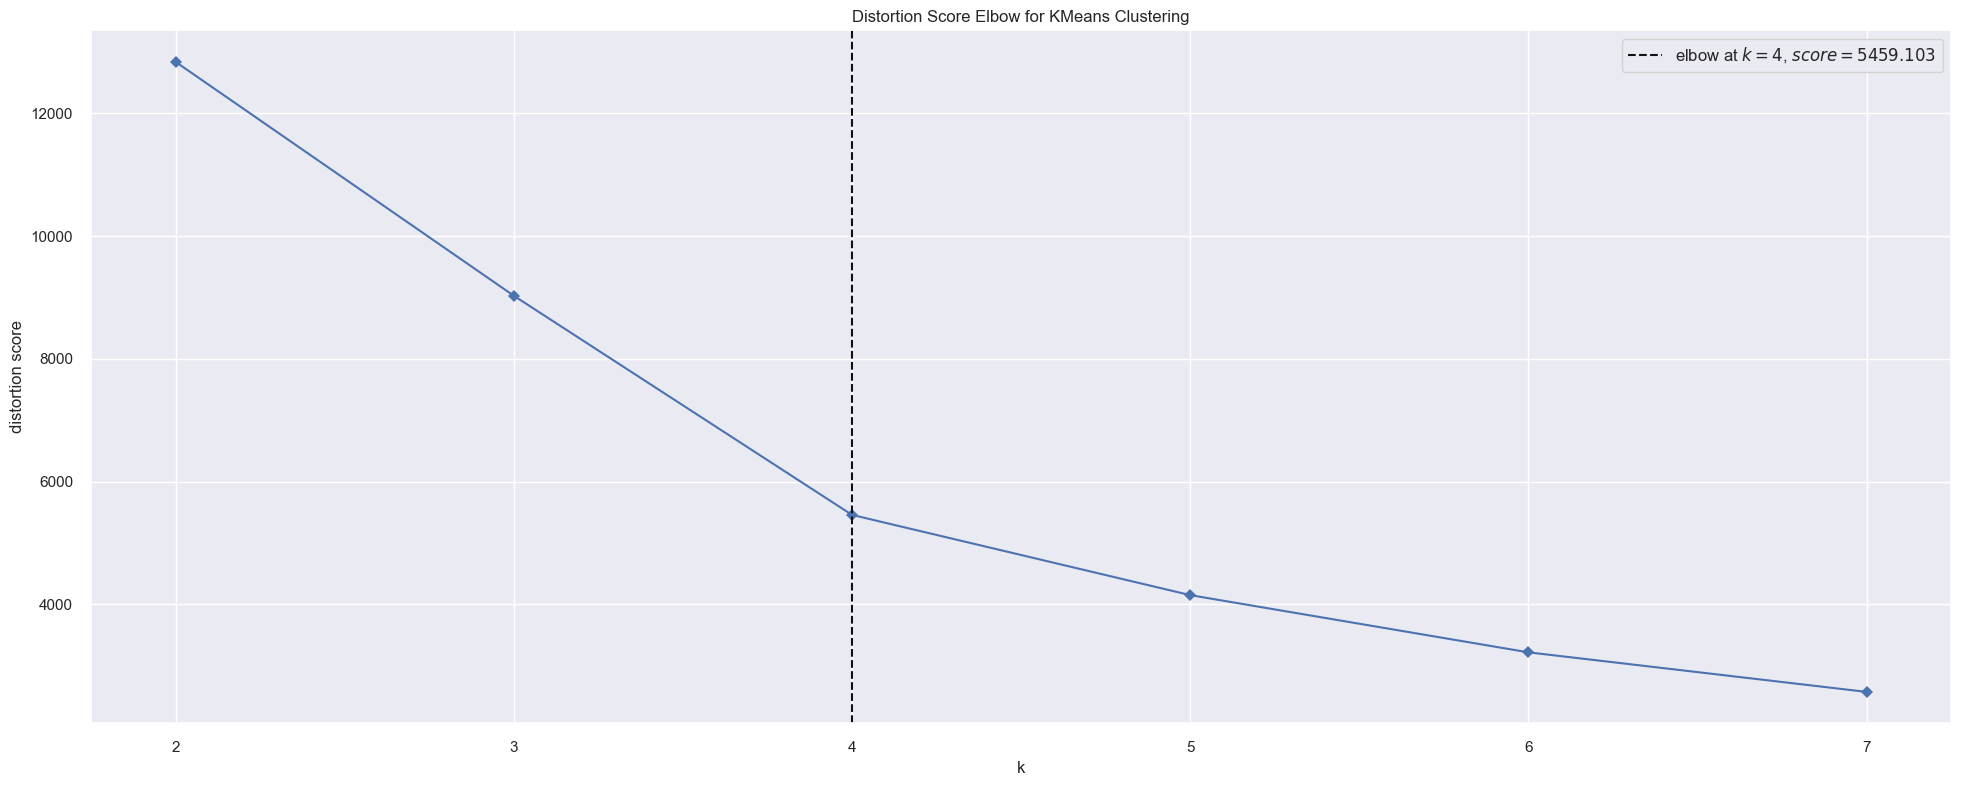

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [149]:
kmeans = KElbowVisualizer( c.KMeans(), k=clusters, timings=False )
kmeans.fit( X )
kmeans.show()

### 7.2. Silhouette Score

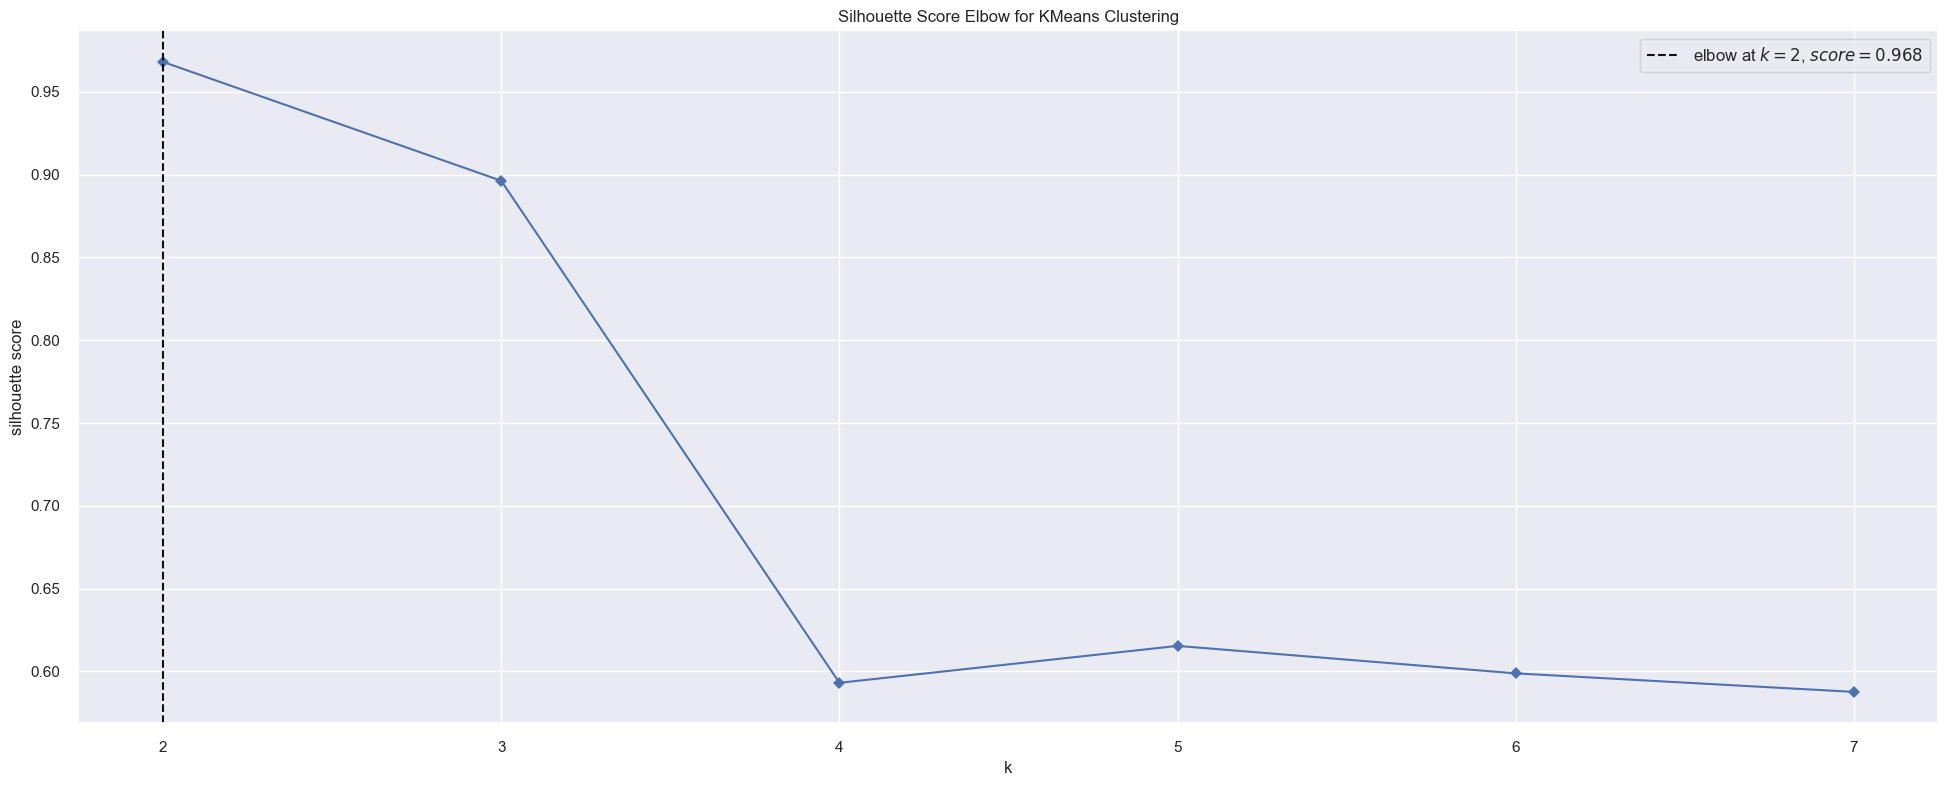

<AxesSubplot:title={'center':'Silhouette Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='silhouette score'>

In [150]:
kmeans = KElbowVisualizer( c.KMeans(), k=clusters, metric='silhouette',  timings=False )
kmeans.fit( X )
kmeans.show()

### 7.3 Silhouette Analysis

In [151]:
X.head()

,gross_revenue,recency_days,invoice_no,avg_ticket
0,0.378073,2.791512,3.893141,-0.033934
1,0.135815,-0.361004,0.621632,-0.033422
2,0.525560,-0.899726,1.406794,-0.026617
3,-0.120552,0.028072,0.098191,-0.023239
4,-0.128660,2.402435,-0.163530,0.152448


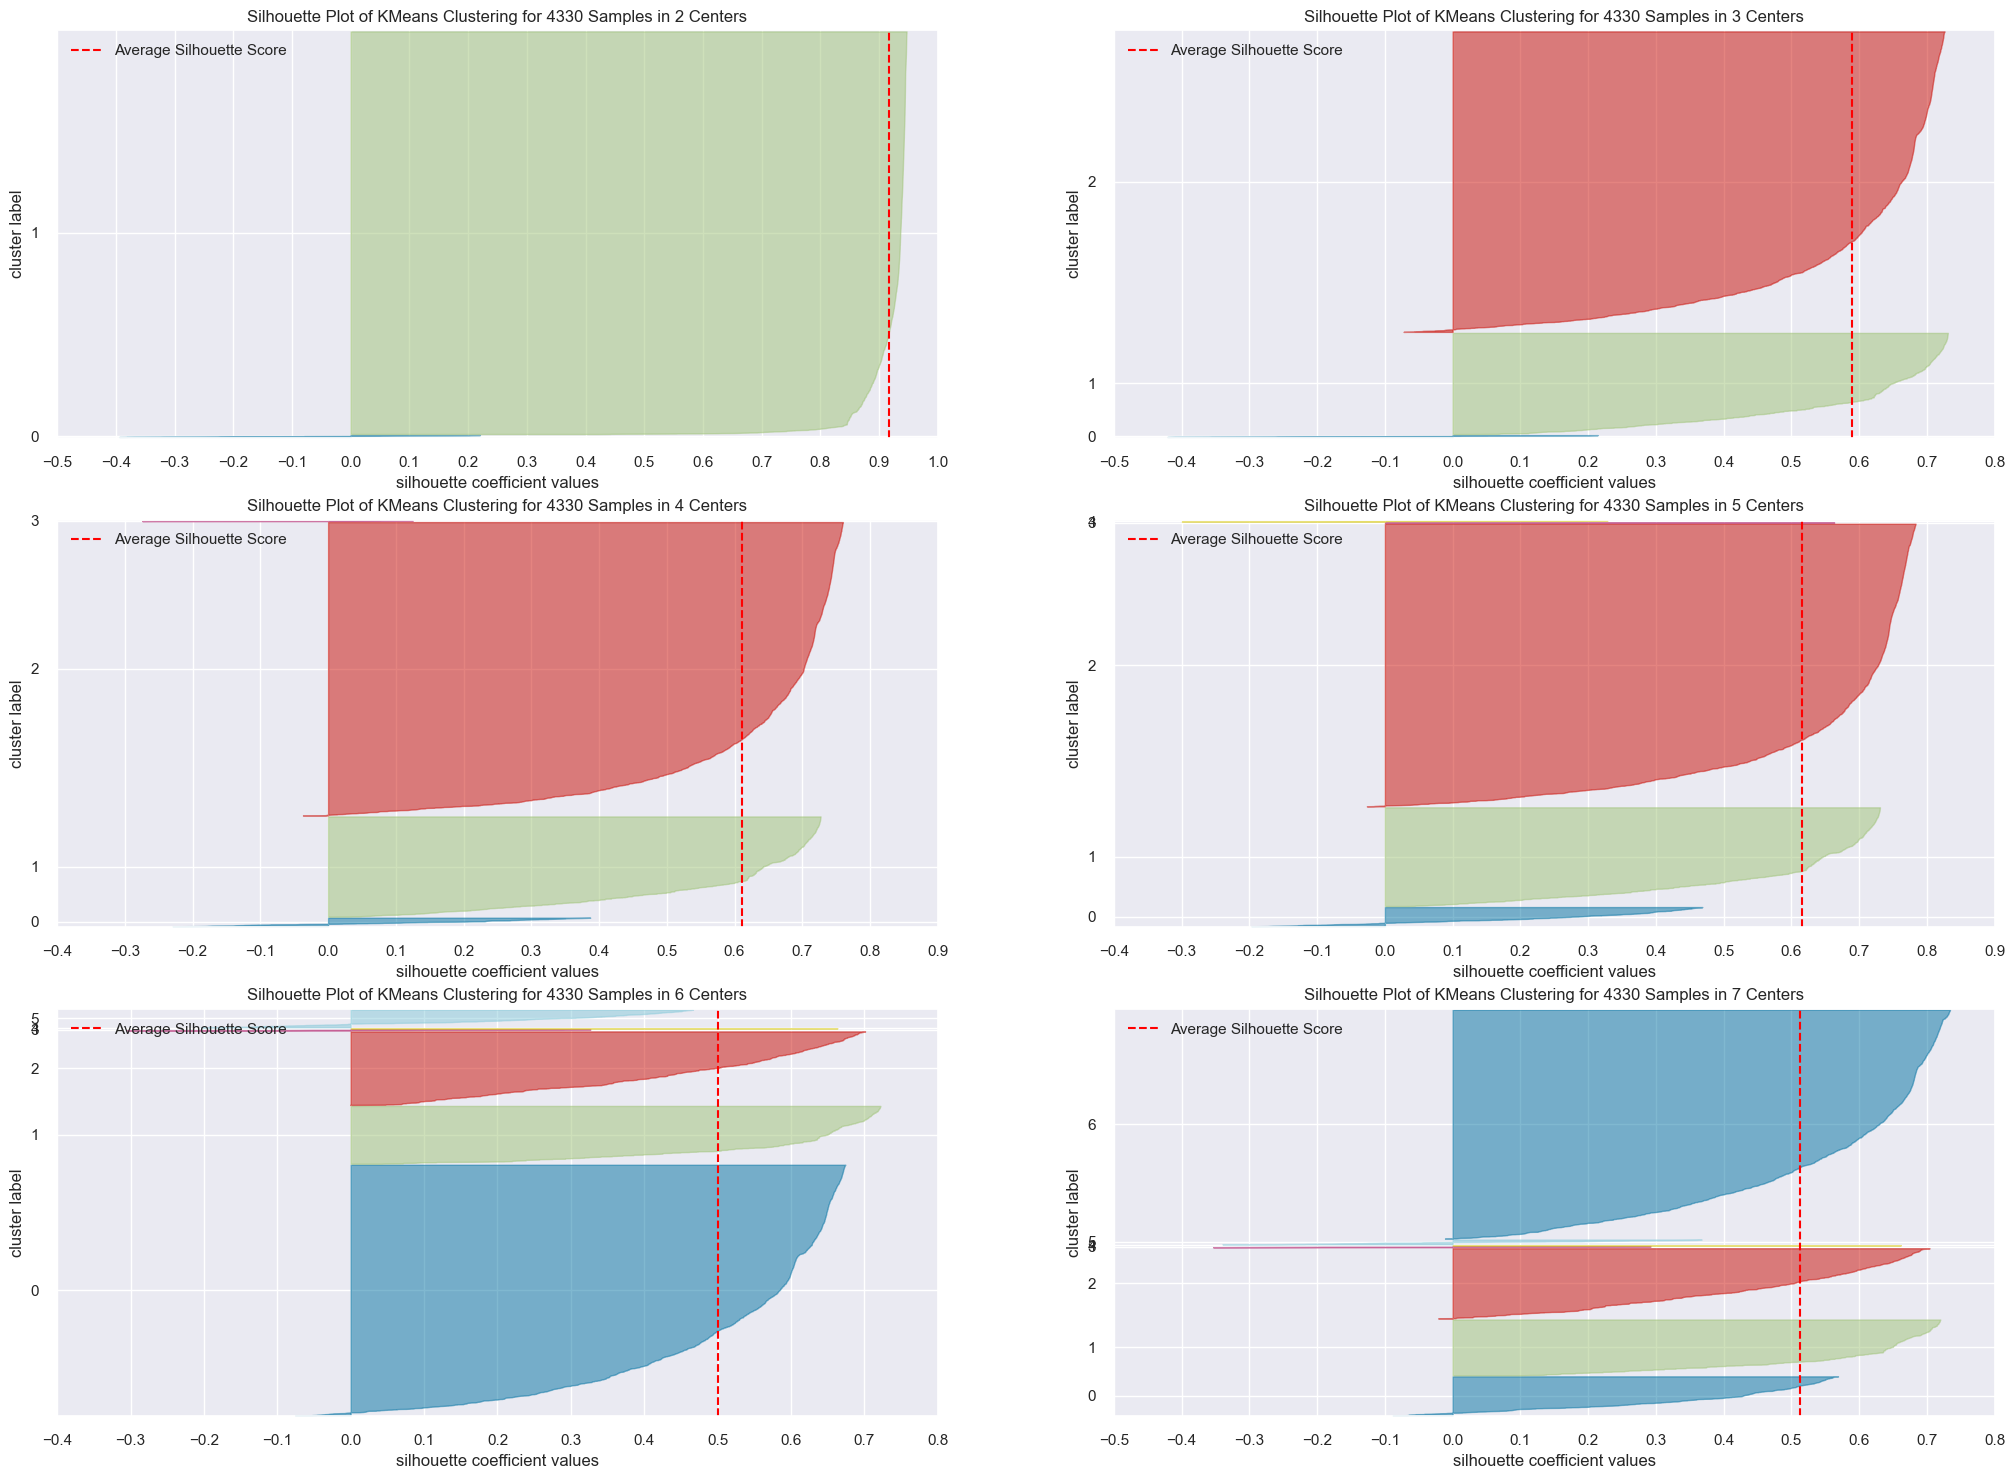

In [152]:
fig, ax = plt.subplots( 3, 2, figsize=(25, 18) )


for k in clusters:
    km = c.KMeans( n_clusters=k, init='random', n_init=10, max_iter=100, random_state=42 )
    q, mod = divmod( k, 2 )

    visualizer = SilhouetteVisualizer( km, colors='yellowbrick', ax=ax[q-1][ mod ] )
    visualizer.fit ( X )
    visualizer.finalize()

## <font color='red'> 8.0. Model Training </font>

### 8.1. K-Means

In [153]:
# model definition
k = 3
kmeans = c.KMeans( init='random', n_clusters=k, n_init=10, max_iter=300, random_state=42 )

# model training
kmeans.fit( X )

# clustering
labels = kmeans.labels_

### 8.2. Cluster Validation

In [154]:
## WSS ( Within-Cluster Sum of Square )
print( 'WSS Value: {}'.format( kmeans.inertia_ ) )

## SS ( Silhouette Score )
print ( 'SS value: {}'.format( m.silhouette_score( X, labels, metric='euclidean' ) ) )

WSS Value: 9408.255050647296
SS value: 0.5893633811956626


## <font color='red'> 9.0. Cluster Analysis </font>

In [155]:
df9 = df6.copy()
df9['cluster'] = labels
df9.head()

,customer_id,gross_revenue,recency_days,invoice_no,avg_ticket,cluster
0,17850,0.378073,2.791512,3.893141,-0.033934,1
1,13047,0.135815,-0.361004,0.621632,-0.033422,2
2,12583,0.525560,-0.899726,1.406794,-0.026617,2
3,13748,-0.120552,0.028072,0.098191,-0.023239,2
4,15100,-0.128660,2.402435,-0.163530,0.152448,1


### 9.1. Visualization Inspection

In [156]:
#fig = px.scatter_3d( df9, x='recency_days', y='invoice_no', z='gross_revenue', color='cluster' )
#fig.show()

/Users/thiago/Thiago/Data_Science/comunidade_ds/insiders_clustering/ins_clustenv/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(


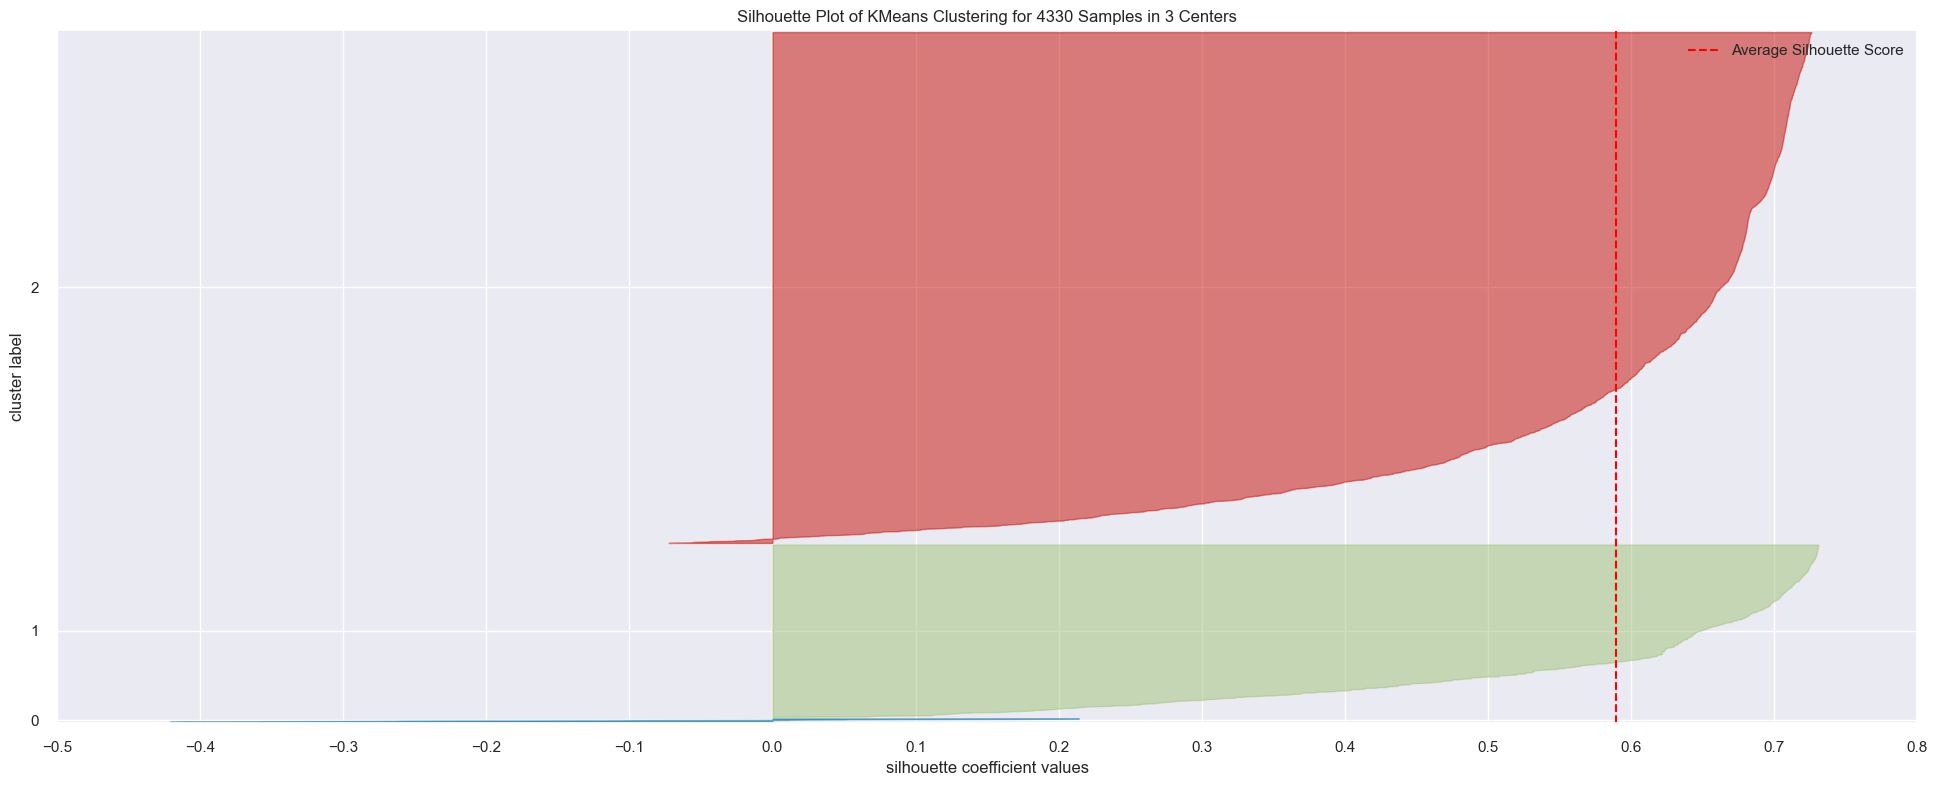

In [157]:
visualizer = SilhouetteVisualizer( kmeans, colors='yellowbrick' )
visualizer.fit( X )
visualizer.finalize()

### 9.2. 2D Plot

In [158]:
df9.head(10)

,customer_id,gross_revenue,recency_days,invoice_no,avg_ticket,cluster
0,17850,0.378073,2.791512,3.893141,-0.033934,1
1,13047,0.135815,-0.361004,0.621632,-0.033422,2
2,12583,0.525560,-0.899726,1.406794,-0.026617,2
3,13748,-0.120552,0.028072,0.098191,-0.023239,2
4,15100,-0.128660,2.402435,-0.163530,0.152448,1
5,15291,0.291892,-0.670270,1.275934,-0.015439,2
6,14688,0.404970,-0.849844,2.191956,-0.034568,2
7,17809,0.380396,-0.760057,1.014213,0.014095,2
8,15311,6.592891,-0.919678,11.352180,-0.028903,0
9,16098,-0.001884,-0.051739,0.359911,-0.025914,2


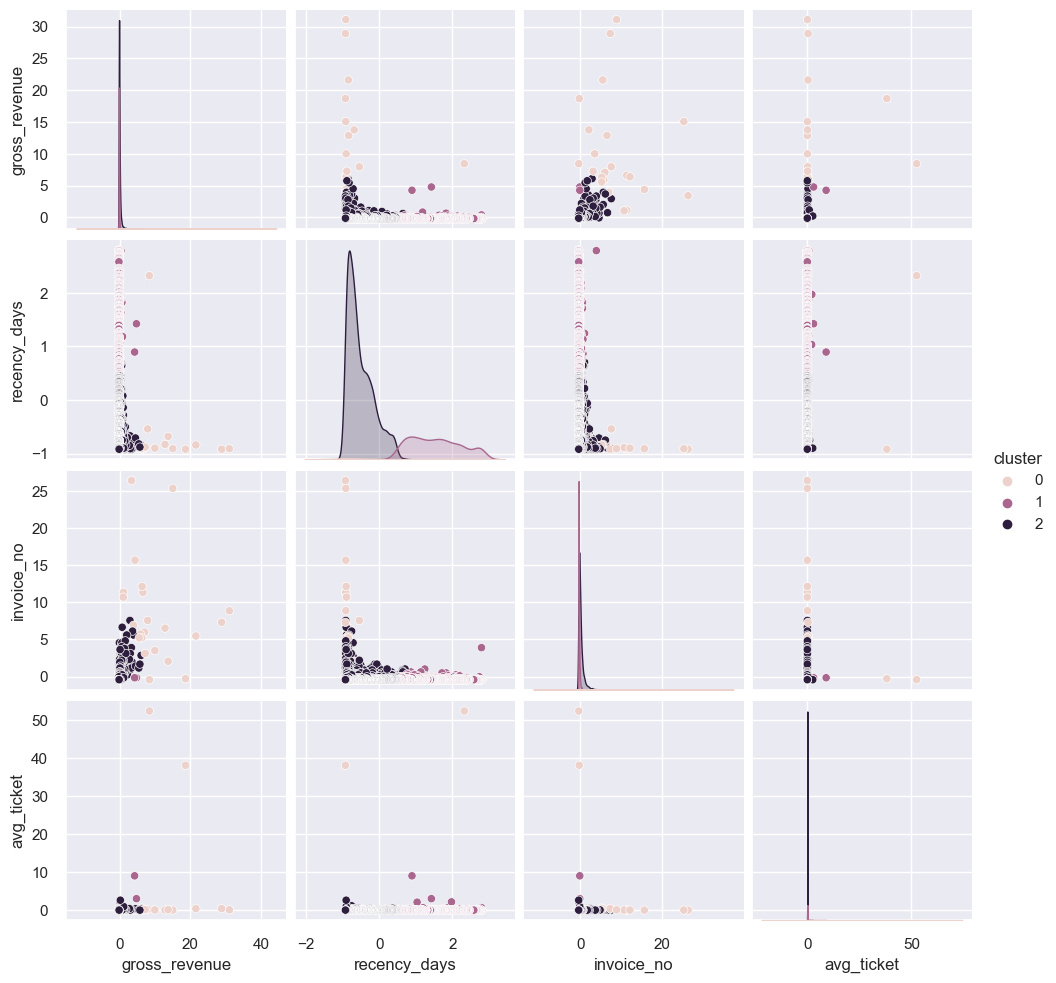

In [159]:
df_viz = df9.drop( columns='customer_id', axis=1 )
sns.pairplot( df_viz, hue='cluster' )


### 9.3. UMAP

In [160]:
X.head()

,gross_revenue,recency_days,invoice_no,avg_ticket
0,0.378073,2.791512,3.893141,-0.033934
1,0.135815,-0.361004,0.621632,-0.033422
2,0.525560,-0.899726,1.406794,-0.026617
3,-0.120552,0.028072,0.098191,-0.023239
4,-0.128660,2.402435,-0.163530,0.152448


<AxesSubplot:xlabel='embedding_x', ylabel='embedding_y'>

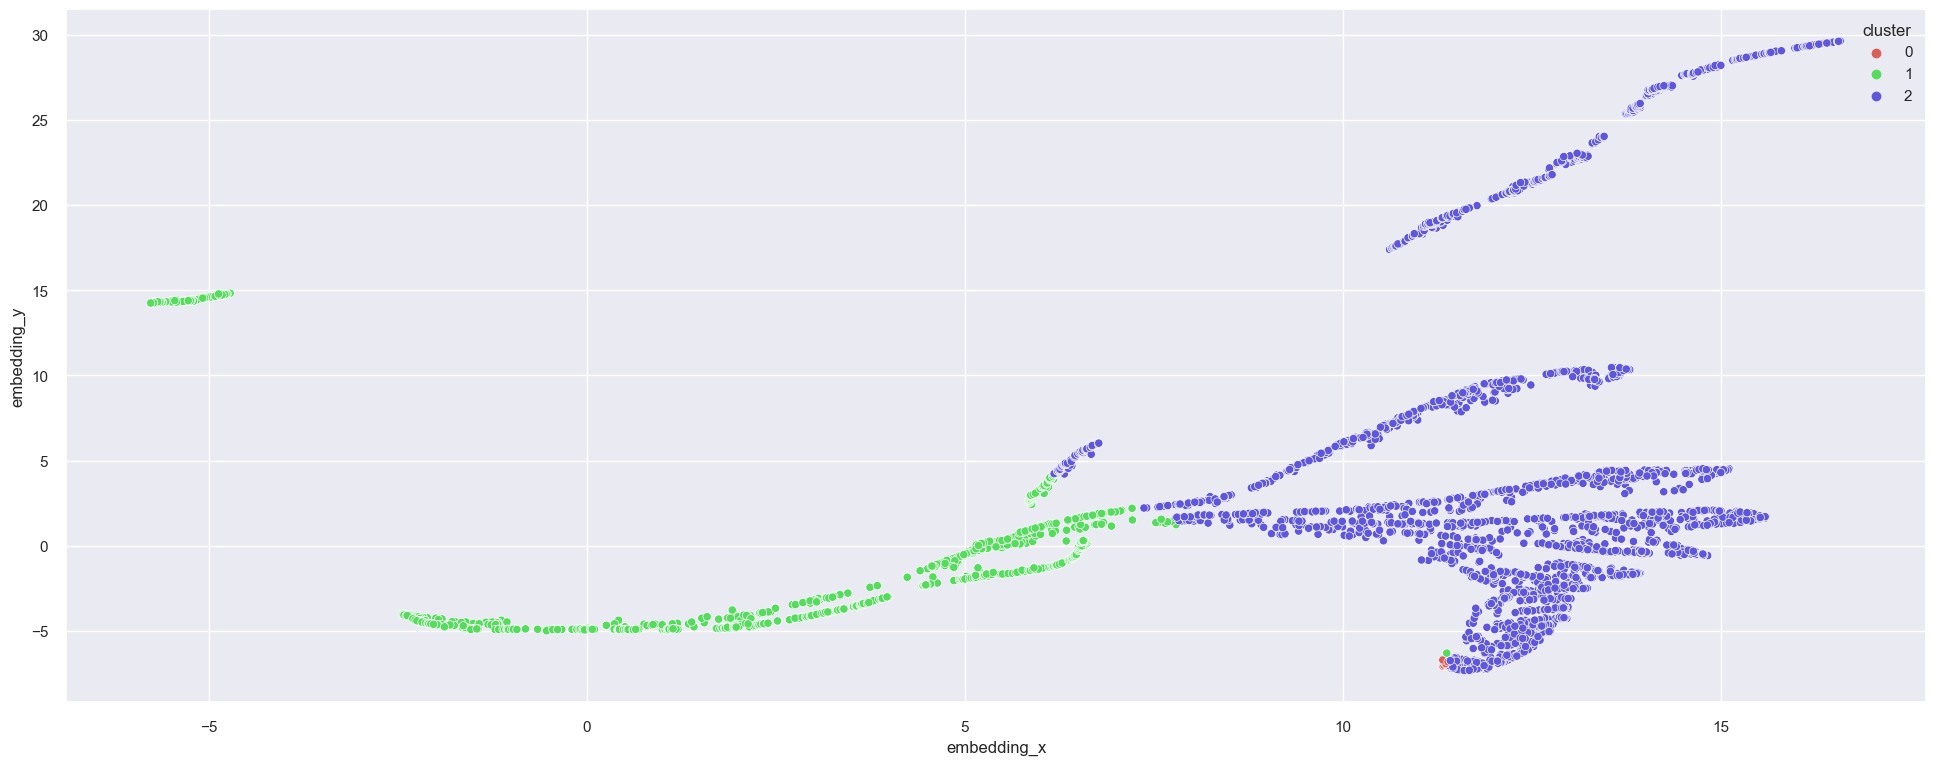

In [166]:
reducer = umap.UMAP( n_neighbors=90, random_state = 42 )
embedding = reducer.fit_transform( X ) # espaço projetado

# embeddind
df_viz['embedding_x'] = embedding[:,0]
df_viz['embedding_y'] = embedding[:,1]

# plot UMAP
sns.scatterplot( x='embedding_x', y='embedding_y', hue='cluster', palette=sns.color_palette( 'hls', n_colors=len( df_viz['cluster'].unique() ) ), data=df_viz )


### 9.2. Cluster Profile

In [162]:
df9.head()

,customer_id,gross_revenue,recency_days,invoice_no,avg_ticket,cluster
0,17850,0.378073,2.791512,3.893141,-0.033934,1
1,13047,0.135815,-0.361004,0.621632,-0.033422,2
2,12583,0.525560,-0.899726,1.406794,-0.026617,2
3,13748,-0.120552,0.028072,0.098191,-0.023239,2
4,15100,-0.128660,2.402435,-0.163530,0.152448,1


In [163]:
# Number of Customer
df_cluster = df9[['customer_id', 'cluster']].groupby('cluster').count().reset_index()
df_cluster['perc_cluster'] = 100 * ( df_cluster['customer_id'] / df_cluster['customer_id'].sum() )

# Average Gross Revenue
df_avg_gross_revenue = df9[['gross_revenue', 'cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge( df_cluster, df_avg_gross_revenue, how='inner', on='cluster')

# Average Recency Days
df_avg_recency_days = df9[['recency_days', 'cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge( df_cluster, df_avg_recency_days, how='inner', on='cluster')

# Average Invoice_no
df_invoice_no = df9[['invoice_no', 'cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge( df_cluster, df_invoice_no, how='inner', on='cluster')

# Avg Ticket
df_ticket = df9[['avg_ticket', 'cluster' ]].groupby( 'cluster' ).mean().reset_index()
df_cluster = pd.merge( df_cluster, df_ticket, how='inner', on='cluster' )

df_cluster

,cluster,customer_id,perc_cluster,gross_revenue,recency_days,invoice_no,avg_ticket
0,0,22,0.508083,10.330045,-0.722419,8.437564,4.189470
1,1,1086,25.080831,-0.164748,1.538960,-0.350542,-0.008683
2,2,3222,74.411085,-0.015005,-0.513786,0.060541,-0.025679


### Cluster 01: ( Candidato à Insider )
    - Número de customers: 6 ( 14% dos customers )
    - Recência em média: 7 dias
    - Compras em média: 89 compras
    - Receita em média: $182.182,00

### Cluster 02:
    - Número de customers: 31 ( 71% dos customers )
    - Recência em média: 14 dias
    - Compras em média: 53 compras
    - Receita em média: $40.543,52

### Cluster 03:
    - Número de customers: 4335 ( 99% dos customers )
    - Recência em média: 92 dias
    - Compras em média: 5 compras
    - Receita em média: $1.372,57

## <font color='red'> 10.0 Deploy To Production </font>